# Deploying Various MNIST Models on Kubernetes 

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup kubeflow and seldon-core. This notebook will show various rolling deployments of the trained models

 * Single model
 * AB Test between 2 models
 * Multi-Armed Bandit over 3 models
 
### Dependencies
 
  * Tensorflow
  * grpcio package
 

# Setup

Set kubectl to use the namespace where you installed kubeflow and seldon. In the README it is kubeflow-seldon

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=kubeflow

Context "my-kubeflow" modified.


In [2]:
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [3]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.




**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n kubeflow -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n kubeflow 8002:80
```

# Deploy Single Tensorflow Model

In [ ]:
get_graph("../k8s_serving/serving_model.json",'r')

In [4]:
!pygmentize ../k8s_serving/serving_model.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "mnist-classifier"
    },
    "spec": {
        "annotations": {
            "deployment_version": "v1",
            "project_name": "MNIST Example",
	    "seldon.io/engine-separate-pod": "false",
	    "seldon.io/rest-connection-timeout": "100"
        },
        "name": "mnist-classifier",
        "predictors": [
            {
                "annotations": {
                    "predictor_version": "v1"
                },
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/deepmnistclassifier_runtime:0.2",
                                "imagePullPolicy": "Always",
                                "name": "tf-model",
                                "volumeMounts": [
    

In [4]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment.machinelearning.seldon.io/mnist-classifier created


In [5]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier-261fcc8 replicas:1 replicasAvailable:1]] state:Available]

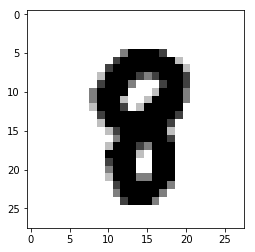

<Response [200]>
{'meta': {'puid': 'ugpdkdbvjjn819lspftlqs23m2', 'tags': {}, 'routing': {}, 'requestPath': {'tf-model': 'seldonio/deepmnistclassifier_runtime:0.2'}, 'metrics': []}, 'data': {'names': ['class:0', 'class:1', 'class:2', 'class:3', 'class:4', 'class:5', 'class:6', 'class:7', 'class:8', 'class:9'], 'ndarray': [[3.5626260341814486e-06, 5.376360832087812e-07, 0.0025569673161953688, 0.0026099802926182747, 0.0022327271290123463, 0.005766032729297876, 3.0075443646637723e-05, 1.2252386113686953e-05, 0.967466413974762, 0.019321538507938385]]}}
{
  "meta": {
    "puid": "ugpdkdbvjjn819lspftlqs23m2",
    "tags": {},
    "routing": {},
    "requestPath": {
      "tf-model": "seldonio/deepmnistclassifier_runtime:0.2"
    },
    "metrics": []
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6",
      "class:7",
      "class:8",
      "class:9"
    ],
    "ndarray": [
      [
        3.56262

In [4]:
utils.predict_rest_mnist(mnist)

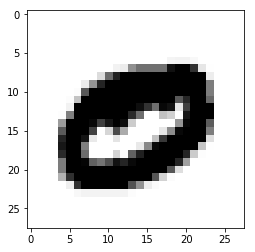

{
  "class:0": "0.95",
  "class:1": "0.00",
  "class:2": "0.00",
  "class:3": "0.00",
  "class:4": "0.00",
  "class:5": "0.05",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.00"
}


In [7]:
utils.predict_grpc_mnist(mnist)

# Start load test

In [5]:
!kubectl label nodes $(kubectl get nodes -o jsonpath='{.items[0].metadata.name}') role=locust

node/gke-my-kubeflow-default-pool-946c7308-2p2h labeled


In [6]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace kubeflow \
    --repo https://storage.googleapis.com/seldon-charts \
    --set locust.script=mnist_rest_locust.py \
    --set locust.host=http://mnist-classifier:8000 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=1 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Sat Jan 19 18:32:16 2019
NAMESPACE: kubeflow
STATUS: DEPLOYED

RESOURCES:
==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP    EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.27.247.42  <none>       5557:31050/TCP,5558:31251/TCP,8089:30504/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS             RESTARTS  AGE
locust-slave-1-jnj5x   0/1    ContainerCreating  0         0s
locust-master-1-qn4lj  0/1    ContainerCreating  0         0s




In [27]:
!helm install seldon-core-loadtesting --name loadtest  \
    --namespace kubeflow \
    --repo https://storage.googleapis.com/seldon-charts \
    --set image.release=0.7 \
    --set locust.script=mnist_grpc_locust.py \
    --set locust.host=mnist-classifier:5001 \
    --set oauth.enabled=false \
    --set oauth.key=oauth-key \
    --set oauth.secret=oauth-secret \
    --set locust.hatchRate=1 \
    --set locust.clients=1 \
    --set loadtest.sendFeedback=0 \
    --set locust.minWait=0 \
    --set locust.maxWait=0 \
    --set replicaCount=1 \
    --set data.size=784


NAME:   loadtest
LAST DEPLOYED: Mon Nov 19 16:43:28 2018
NAMESPACE: kubeflow
STATUS: DEPLOYED

RESOURCES:
==> v1/ReplicationController
NAME             DESIRED  CURRENT  READY  AGE
locust-slave-1   1        1        0      0s
locust-master-1  1        1        0      0s

==> v1/Service
NAME             TYPE      CLUSTER-IP    EXTERNAL-IP  PORT(S)                                       AGE
locust-master-1  NodePort  10.7.242.134  <none>       5557:30235/TCP,5558:30987/TCP,8089:30749/TCP  0s

==> v1/Pod(related)
NAME                   READY  STATUS             RESTARTS  AGE
locust-slave-1-cvrtz   0/1    ContainerCreating  0         0s
locust-master-1-4s84d  0/1    ContainerCreating  0         0s




# Rolling update to AB Test
 Run an AB Test between 2 models:
  * Tensorflow neural network model
  * Scikit-learn random forest.
 

In [ ]:
get_graph("../k8s_serving/ab_test_sklearn_tensorflow.json",'r')

In [ ]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

In [7]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


In [14]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier-a00aaef replicas:1 replicasAvailable:1]] state:Available]

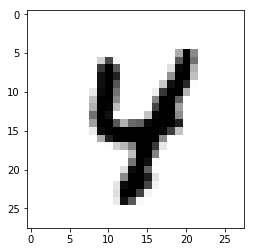

<Response [200]>
{'meta': {'puid': 'lq43ejmqvcs5onsuccqttmlrbl', 'tags': {}, 'routing': {'random-ab-test': 0}, 'requestPath': {'random-ab-test': '', 'tf-model': 'seldonio/deepmnistclassifier_runtime:0.2'}, 'metrics': []}, 'data': {'names': ['class:0', 'class:1', 'class:2', 'class:3', 'class:4', 'class:5', 'class:6', 'class:7', 'class:8', 'class:9'], 'ndarray': [[2.240154373112091e-07, 2.3010157690350752e-07, 2.169100298488047e-05, 1.2663235793297645e-05, 0.9934784173965454, 0.00038023709203116596, 7.36499932827428e-05, 0.0010663875145837665, 0.002716399496421218, 0.002250067889690399]]}}
{
  "meta": {
    "puid": "lq43ejmqvcs5onsuccqttmlrbl",
    "tags": {},
    "routing": {
      "random-ab-test": 0
    },
    "requestPath": {
      "random-ab-test": "",
      "tf-model": "seldonio/deepmnistclassifier_runtime:0.2"
    },
    "metrics": []
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6

In [8]:
utils.predict_rest_mnist(mnist)

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


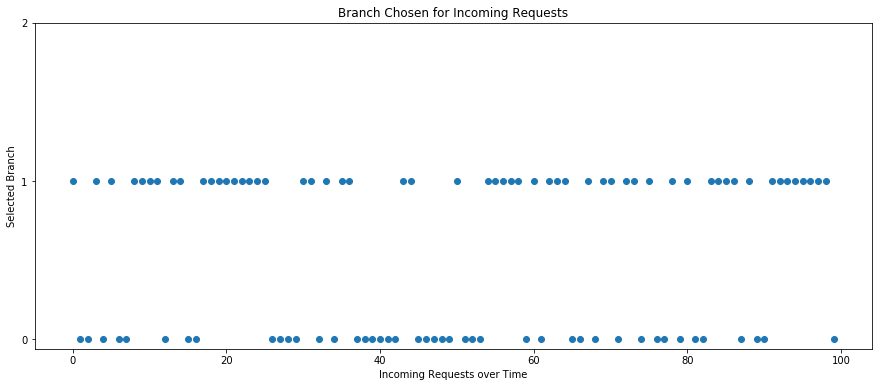

In [4]:
utils.evaluate_abtest(mnist,100)

# Rolling Update to Multi-Armed Bandit
Run a epsilon-greey multi-armed bandit over 3 models:
  * Tensorflow neural network model
  * Scikit-learn random forest model
  * R least-squares model
  

In [ ]:
get_graph("../k8s_serving/epsilon_greedy_3way.json",'r')

In [5]:
!pygmentize ../k8s_serving/epsilon_greedy_3way.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpecs": [{
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.2",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.2",
				"name": "sk-model",
                                "volumeMounts": [
               

In [6]:
!kubectl apply -f ../k8s_serving/epsilon_greedy_3way.json

seldondeployment.machinelearning.seldon.io/mnist-classifier configured


In [19]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier-25882a8 replicas:1 replicasAvailable:1]] state:Available]

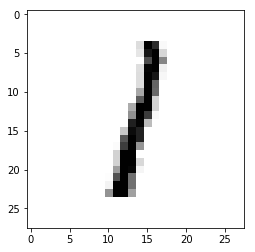

{
  "meta": {
    "puid": "pe2u6u1pfqubu5lv26klo059h0",
    "tags": {},
    "routing": {
      "eg-router": 1
    },
    "requestPath": {
      "eg-router": "seldonio/mab_epsilon_greedy:1.1",
      "tf-model": "seldonio/deepmnistclassifier_runtime:0.2"
    },
    "metrics": []
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6",
      "class:7",
      "class:8",
      "class:9"
    ],
    "ndarray": [
      [
        1.2974190212844405e-05,
        0.9442684650421143,
        0.03091631457209587,
        0.008906111121177673,
        1.6680205590091646e-05,
        0.0016131680458784103,
        0.0007403350318782032,
        0.00032803515205159783,
        0.012802253477275372,
        0.0003956942236982286
      ]
    ]
  }
}
{
  "class:0": "0.00",
  "class:1": "0.94",
  "class:2": "0.03",
  "class:3": "0.01",
  "class:4": "0.00",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0

In [7]:
utils.predict_rest_mnist(mnist)

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
[1.0, 79.0, 4.0]


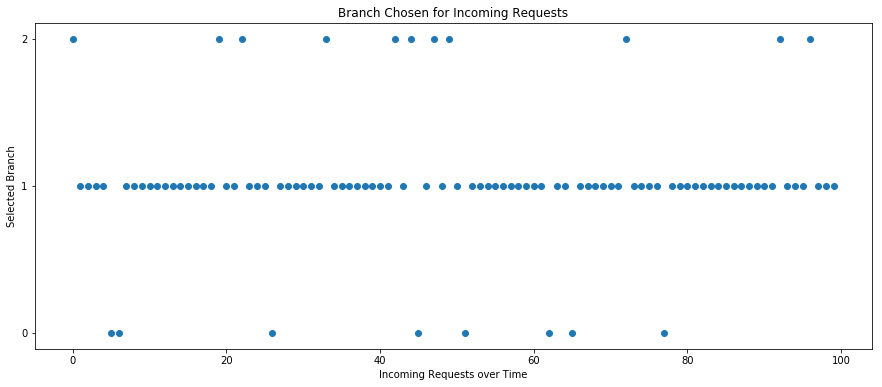

In [8]:
utils.evaluate_egreedy(mnist,100)